### Conditional encoding and normalizing flows for offshore wind speed short-term forecasting

This notebook reproduces part of the results published in Marcille et al. 2024. 
- Data and model loading
- Predictions and plots 
- Error metrics


In [44]:
import pickle
import torch
import io
import scipy
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.trainer.supporters import CombinedLoader
from tqdm import tqdm
from utils import build_cov_matrix
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scoring.sampling import sample_flow, sample_gaussian
from scoring.scores import proba_scores, RMSE_global, deterministic_scores, rank_histogram
from models.Analogs import Analogs
from models.GBM import GBM_quantile

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: 
            return super().find_class(module, name)

ImportError: cannot import name 'rank_histogram' from 'scoring.scores' (c:\Users\robin.marcille\Documents\GitHub\conve_stf_meteonet\scoring\scores.py)

#### Load input and output data

In [12]:
with open('./data/X_arome.pickle', 'rb') as f:
    X_arome = CPU_Unpickler(f).load()
with open('./data/X_gs.pickle', 'rb') as f:
    X_gs = CPU_Unpickler(f).load()
with open('./data/Y.pickle', 'rb') as f:
    y = CPU_Unpickler(f).load()
with open('./data/X_closest.pickle', 'rb') as f:
    X_closest = CPU_Unpickler(f).load()

#Reduced dataset
with open('./data/X_reduced.pickle', 'rb') as f:
    X_reduced = CPU_Unpickler(f).load()


with open('./data/scalers.pickle', 'rb') as f:
    scalers = CPU_Unpickler(f).load()

In [13]:
N_test_samples = y["test"].shape[0]
print ('\n########################')
print ('#### Target shape ######')
print ('########################\n')

print(f'Number of test samples = {y["test"].shape[0]}')
print(f'Number of predicted variables = {y["test"].shape[1]}')
print(f'Number of lead times = {y["test"].shape[2]}')

print ('\n########################')
print ('###### GS shape ########')
print ('######################## \n')

print(f'Number of test samples = {X_gs["test"].shape[0]}')
print(f'Number of input features = {X_gs["test"].shape[1]}')
print(f'Number of lead times = {X_gs["test"].shape[2]}')


print ('\n########################')
print ('###### NWP shape #######')
print ('########################\n')

print(f'Number of test samples = {X_arome["test"].shape[0]}')
print(f'Number of input features = {X_arome["test"].shape[1]}')
print(f'Number of latitude points = {X_arome["test"].shape[2]}')
print(f'Number of longitude points = {X_arome["test"].shape[3]}')
print(f'Number of lead times = {X_arome["test"].shape[4]}')


########################
#### Target shape ######
########################

Number of test samples = 798
Number of predicted variables = 2
Number of lead times = 60

########################
###### GS shape ########
######################## 

Number of test samples = 798
Number of input features = 46
Number of lead times = 60

########################
###### NWP shape #######
########################

Number of test samples = 798
Number of input features = 5
Number of latitude points = 80
Number of longitude points = 80
Number of lead times = 6


In [14]:
dataloader = {}
batch_size = 256
X = {}
for phase in ['train', 'val', 'test']:
    X[phase] = {'gs':X_gs[phase], 'nwp':X_arome[phase], 'closest':X_closest[phase]}

#### Load trained models

In [15]:
with open('./trained_models/ConvE_STF.pickle', 'rb') as f:
    convestf = CPU_Unpickler(f).load()

with open('./trained_models/ConvE_STF_NF.pickle', 'rb') as f:
    convestf_nf = CPU_Unpickler(f).load()
with open('./trained_models/ConvE_STF_reduced.pickle', 'rb') as f:
    convestf_reduced = CPU_Unpickler(f).load()
with open('./trained_models/gbm.pickle', 'rb') as f:
    gbm = CPU_Unpickler(f).load()
with open('./trained_models/AROME.pickle', 'rb') as f:
    pred_arome = CPU_Unpickler(f).load()

In [16]:
pred_convestf = convestf(X['test'])

In [17]:
pred_convestf_nf = convestf_nf(X['test'])


In [18]:
mean_train_reduced = X_reduced['train'].mean(axis = 0).mean(axis = 1)
std_train_reduced = X_reduced['train'].permute(1, 0, 2).contiguous().view(X_reduced['train'].shape[1], -1).std(axis = 1)

pred_convestf_reduced = convestf_reduced((X_reduced['test'] - mean_train_reduced.unsqueeze(0).unsqueeze(2).tile(X_reduced['test'].shape[0], 1, 60))/std_train_reduced.unsqueeze(0).unsqueeze(2).tile(X_reduced['test'].shape[0], 1, 60))

In [19]:
pred_gbm = gbm.generate_pred(X_reduced)


##### Generate samples - compare distributions

Make a prediction from analogs requires performing a PCA on the reduced dataset to reduce the dimension on the catalog

In [20]:
analogs = Analogs(X_reduced, 
                  y, 
                  k=12, 
                  n_pcs=25, 
                  regression='locally_constant', 
                  leaf_size=50,
                  distance='minkowski')
                  
X_test_analogs = analogs.analogs_input_transform(X_reduced['test'].view(X_reduced['test'].shape[0], -1))
samples_analogs, _, _ = analogs.pred(X_test_analogs, n_samples = 300)
samples_analogs = torch.tensor(samples_analogs).permute(1, 0, 3, 2)

Catalog shape =  torch.Size([2372, 25])
Search catalog shape =  torch.Size([2372, 25])


In [21]:
N_issue_time = pred_arome.shape[0]
N_lead_time = 60
N_samples = 200
N_vars = 2

In [36]:
# samples_nf = sample_flow(pred_convestf_nf, 
#                          convestf_nf.NF.flow, 
#                          n_samples = N_samples)
# samples_nf = samples_nf.reshape(N_issue_time, N_lead_time, N_samples, N_vars).permute(0, 2, 3, 1)

with open('./trained_models/ConvE_STF_NF_samples.pickle', 'rb') as f:
    samples_nf = pickle.load(f)

In [23]:
samples_convestf = sample_gaussian(pred_convestf, N_samples)
samples_convestf = samples_convestf.reshape(N_issue_time, N_lead_time, N_samples, N_vars).permute(0, 2, 3, 1)

In [24]:
samples_convestf_reduced = sample_gaussian(pred_convestf_reduced, N_samples)
samples_convestf_reduced = samples_convestf_reduced.reshape(N_issue_time, N_lead_time, N_samples, N_vars).permute(0, 2, 3, 1)

In [25]:
samples_gbm = gbm.generate_samples(N_samples, ['test'])['test']
samples_gbm = samples_gbm.reshape(N_issue_time, N_lead_time, N_samples, N_vars).permute(0, 2, 3, 1)

100%|██████████| 47880/47880 [06:29<00:00, 122.84it/s]


In [26]:
def unscale_samples_vector(y, scaler_mean, scaler_std):
    n_t, n_samples, n_vars, n_lead = y.shape
    scaler_mean = scaler_mean.unsqueeze(0).unsqueeze(0).unsqueeze(3).tile(n_t, n_samples, 1, n_lead)
    scaler_std = scaler_std.unsqueeze(0).unsqueeze(0).unsqueeze(3).tile(n_t, n_samples, 1, n_lead)
    y = y*scaler_std + scaler_mean
    return y
def unscale_vector(y, scaler_mean, scaler_std):
    n_t, n_vars, n_lead = y.shape
    scaler_mean = scaler_mean.unsqueeze(0).unsqueeze(2).tile(n_t, 1, n_lead)
    scaler_std = scaler_std.unsqueeze(0).unsqueeze(2).tile(n_t, 1, n_lead)
    y = y*scaler_std + scaler_mean
    return y

C:\Users\robin.marcille\AppData\Local\Temp\ipykernel_21200\2849047114.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['N','', 'E', '', 'S', '', 'W', ''])
C:\Users\robin.marcille\AppData\Local\Temp\ipykernel_21200\2849047114.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['N','', 'E', '', 'S', '', 'W', ''])
C:\Users\robin.marcille\AppData\Local\Temp\ipykernel_21200\2849047114.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['N','', 'E', '', 'S', '', 'W', ''])


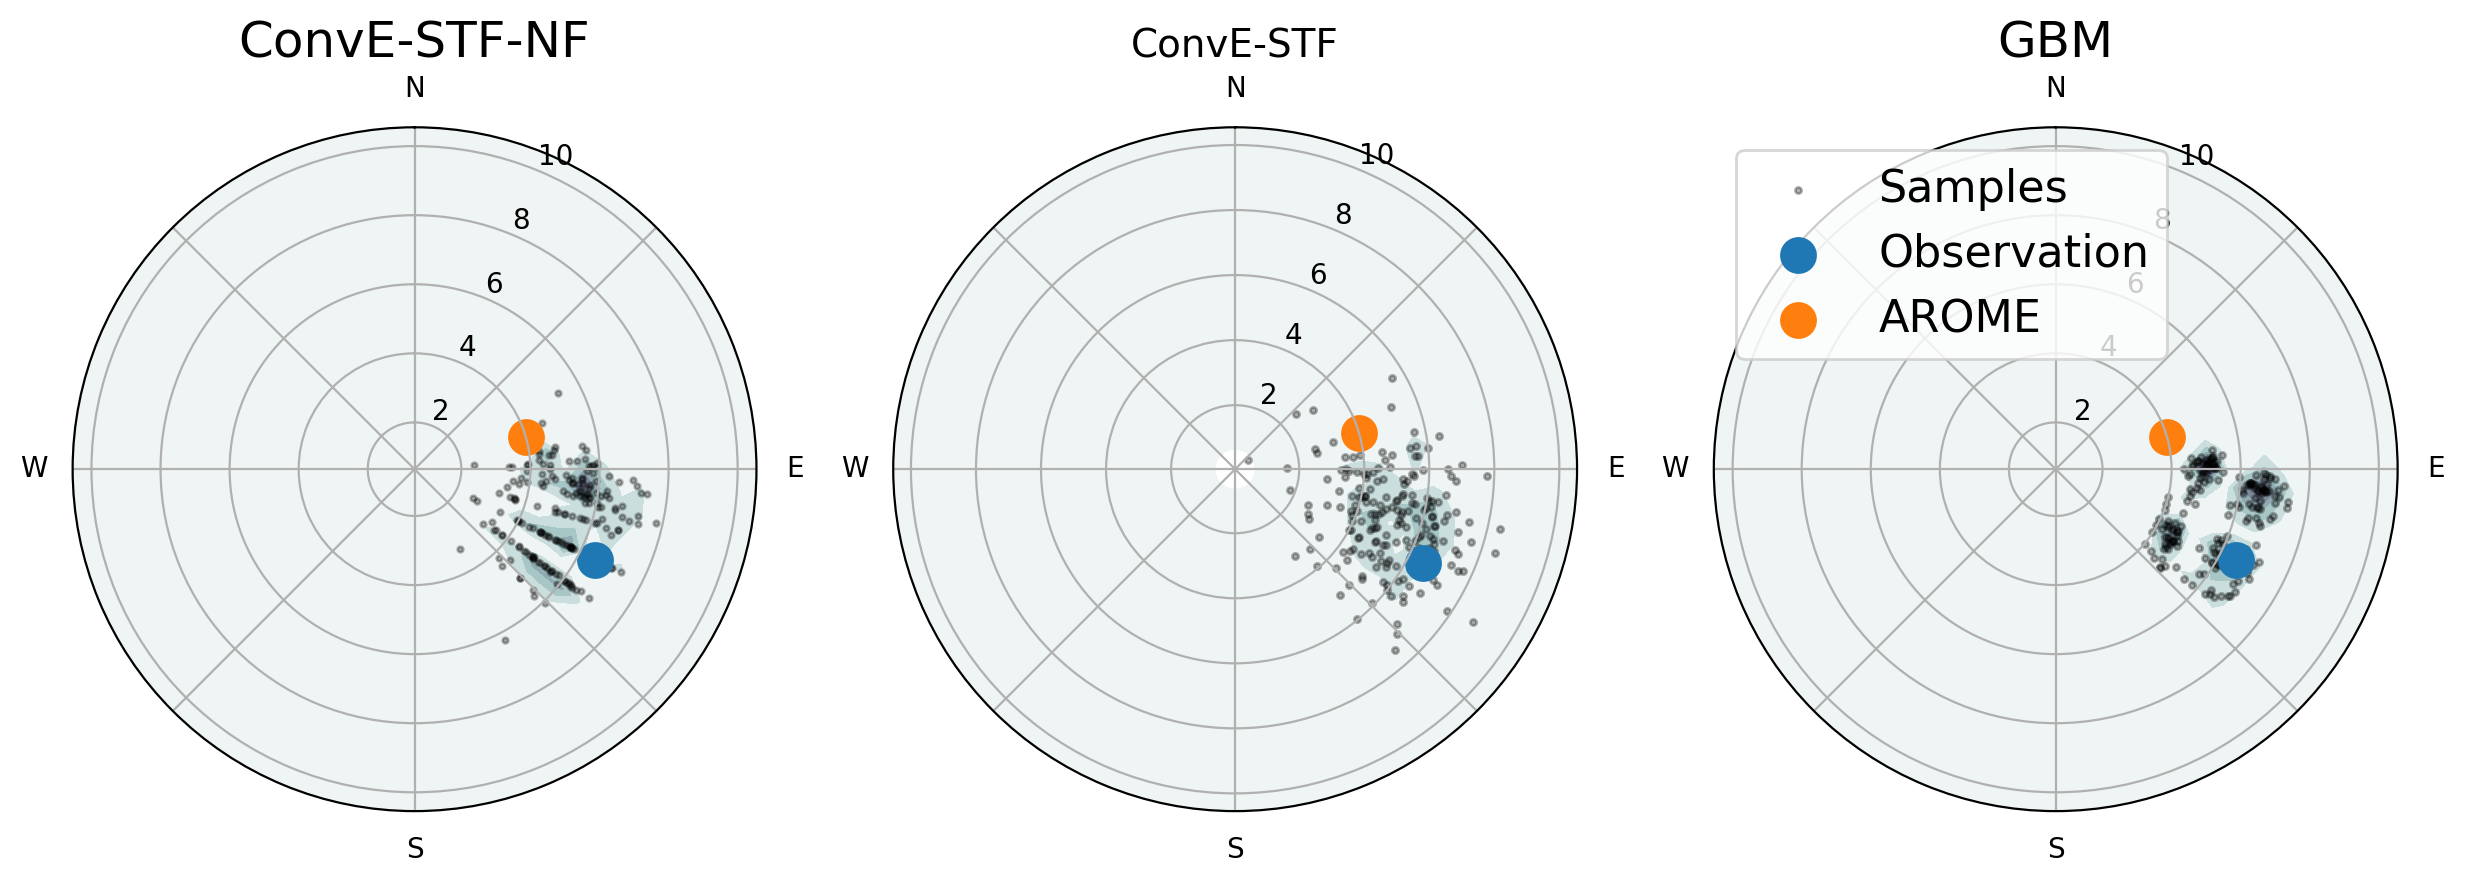

In [27]:

import numpy as np
import math
import matplotlib.pyplot as plt
samples_nf_unscaled = unscale_samples_vector(samples_nf, scalers['target']['mean'], scalers['target']['std'])
samples_convestf_unscaled = unscale_samples_vector(samples_convestf, scalers['target']['mean'], scalers['target']['std'])
samples_gbm_unscaled = unscale_samples_vector(samples_gbm, scalers['target']['mean'], scalers['target']['std'])

y_unscale = unscale_vector(y['test'], scalers['target']['mean'], scalers['target']['std'])

i = random.randint(0, N_issue_time-1)
j = random.randint(0, N_lead_time-1)

r_y = torch.sqrt(y_unscale[i, 0, j]**2 + y_unscale[i, 1, j]**2).numpy()
theta_y =  90 + torch.atan2(-y_unscale[i, 1, j], -y_unscale[i, 0, j]).numpy()

r_arome = torch.sqrt(pred_arome[i, 0, j]**2 + pred_arome[i, 1, j]**2).numpy()
theta_arome =  90 + torch.atan2(-pred_arome[i, 1, j], -pred_arome[i, 0, j]).numpy()


fig, ax = plt.subplots(1, 3, figsize = (15, 15), subplot_kw={'projection': 'polar'})
ax = plt.subplot(1, 3, 1)
thetabins = np.linspace(-5, 365, 73)*math.pi/140
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
r = torch.sqrt(samples_nf_unscaled[i, :, 0, j]**2 + samples_nf_unscaled[i, :, 1, j]**2).numpy()
theta =90 +  torch.atan2(-samples_nf_unscaled[i, :, 1, j], -samples_nf_unscaled[i, :, 0, j]).numpy()
rbins = np.linspace(r.min() -2, r.max() + 3, 20)

hist, theta_edges, r_edges = np.histogram2d(theta%(2*math.pi), r, bins=(thetabins, rbins), density = True)
r_mid     = .5 * (r_edges[:-1] + r_edges[1:])
theta_mid = .5 * (theta_edges[:-1] + theta_edges[1:])
rmesh, thetamesh = np.meshgrid(rbins, thetabins)
levels = [0.2*i for i in range(11)]
pc = ax.contourf(theta_mid, r_mid, hist.T, 10, cmap='bone_r', levels = levels)
ax.scatter(theta% (2*math.pi), r, s = 4, color = 'k', alpha = 0.3)
ax.scatter(theta_y, r_y, marker = 'o', s = 150)
ax.scatter(theta_arome, r_arome, marker = 'o', s = 150)
ax.set_xticklabels(['N','', 'E', '', 'S', '', 'W', ''])

ax.grid(True)
ax.set_title('ConvE-STF-NF', fontsize = 18)



ax = plt.subplot(1, 3, 2)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

r_gauss = torch.sqrt(samples_convestf_unscaled[i, :, 0, j]**2 + samples_convestf_unscaled[i, :, 1, j]**2).numpy()
theta_gauss = 90 + torch.atan2(-samples_convestf_unscaled[i, :, 1, j], -samples_convestf_unscaled[i, :, 0, j]).numpy()
hist, theta_edges, r_edges = np.histogram2d(theta_gauss% (2*math.pi), r_gauss, bins=(thetabins, rbins), density = True)
pc = ax.contourf(theta_mid, r_mid, hist.T, 10, cmap='bone_r', levels = levels)
ax.scatter(theta_gauss% (2*math.pi), r_gauss, s = 5, color = 'k', alpha = 0.3)

ax.scatter(theta_y, r_y, marker = 'o', s = 150)
ax.scatter(theta_arome, r_arome, marker = 'o', s = 150)
ax.set_xticklabels(['N','', 'E', '', 'S', '', 'W', ''])

ax.set_title('ConvE-STF', fontsize = 14)

ax.grid(True)
ax = plt.subplot(1, 3, 3)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

r_gbm = torch.sqrt(samples_gbm_unscaled[i, :, 0, j]**2 + samples_gbm_unscaled[i, :, 1, j]**2).numpy()
theta_gbm = 90 + torch.atan2(-samples_gbm_unscaled[i, :, 1, j], -samples_gbm_unscaled[i, :, 0, j]).numpy()

hist, theta_edges, r_edges = np.histogram2d(theta_gbm% (2*math.pi), r_gbm, bins=(thetabins, rbins), density = True)
pc = ax.contourf(theta_mid, r_mid, hist.T, 20, cmap='bone_r', levels = levels)
ax.scatter(theta_gbm% (2*math.pi), r_gbm, s = 5, color = 'k', alpha = 0.3, label = 'Samples')

ax.scatter(theta_y, r_y, marker = 'o', s = 150, label = 'Observation')
ax.scatter(theta_arome, r_arome, marker = 'o', s = 150, label = 'AROME')
plt.legend(fontsize = 16, loc= 'upper left')

ax.set_title('GBM', fontsize = 18)
ax.set_xticklabels(['N','', 'E', '', 'S', '', 'W', ''])

ax.grid(True)

#### Visualize forecasts

In [28]:
mu_convestf, cov_convestf = build_cov_matrix(pred_convestf)
mu_convestf_reduced, cov_convestf_reduced = build_cov_matrix(pred_convestf_reduced)


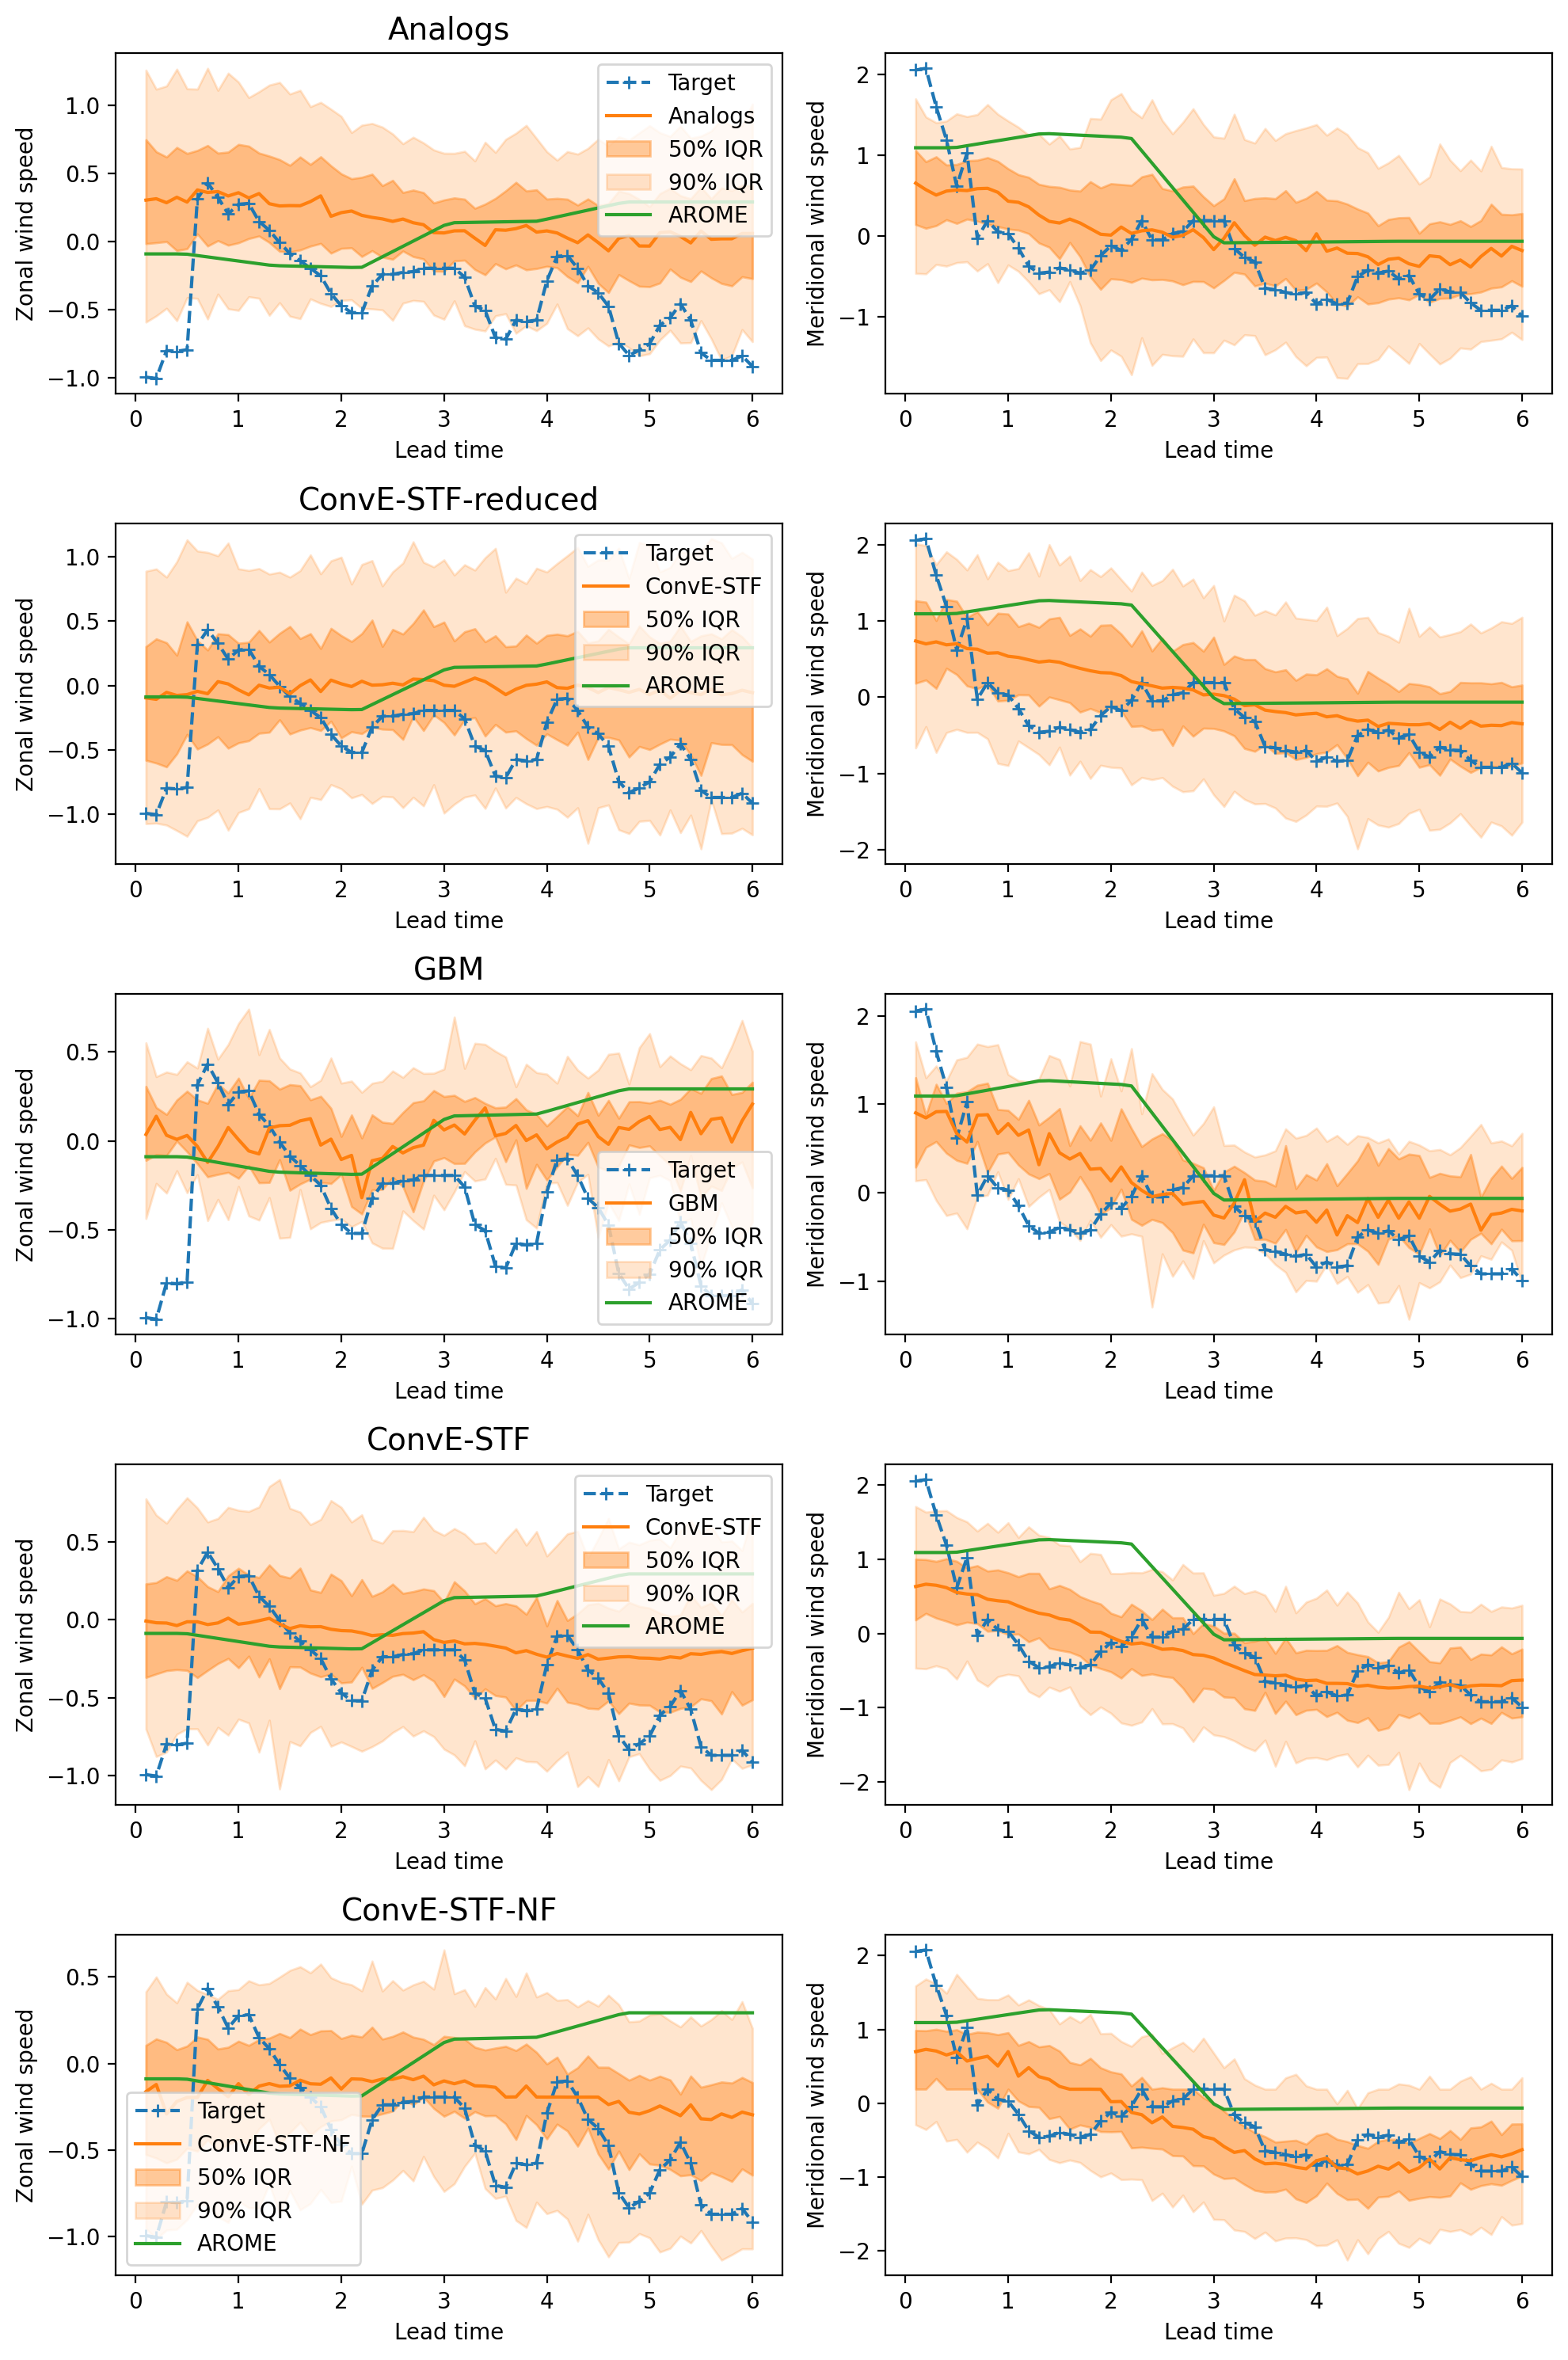

In [29]:
#Select a random sample
i = random.randint(0, N_issue_time-1)
plot_all_models = True
n_time_lead = [0.1*i for i in range(1, 61)]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

pred_arome_scaled = (pred_arome- scalers['target']['mean'].unsqueeze(0).unsqueeze(2).tile(N_issue_time, 1, N_lead_time))/scalers['target']['std'].unsqueeze(0).unsqueeze(2).tile(N_issue_time, 1, N_lead_time)
if plot_all_models:
    #Plot Analogs
    plt.subplots(5, 2, figsize = (10, 15))
    plt.subplot(5, 2, 1)
    plt.title('Analogs', fontsize = 14)
    plt.plot(n_time_lead, y['test'][i, 0, :], '+--', label = 'Target')
    med = scipy.stats.mstats.mquantiles(samples_analogs[i, :, 0, :], prob = [0.5], axis = 0)
    plt.plot(n_time_lead, med[0, :], label = 'Analogs')
    iqr_50 = scipy.stats.mstats.mquantiles(samples_analogs[i, :, 0, :], prob = [0.25,0.75], axis = 0)
    iqr_90 = scipy.stats.mstats.mquantiles(samples_analogs[i, :, 0, :], prob = [0.05,0.95], axis = 0)
    plt.fill_between(n_time_lead, iqr_50[0, :], iqr_50[1, :], alpha = 0.4, color = colors[1], label = '50% IQR')
    plt.fill_between(n_time_lead, iqr_90[0, :], iqr_90[1, :], alpha = 0.2, color = colors[1], label = '90% IQR')    
    plt.plot(n_time_lead, pred_arome_scaled[i, 0, :], label = 'AROME')
    plt.ylabel('Zonal wind speed')
    plt.legend()
    plt.xlabel('Lead time')

    plt.subplot(5, 2, 2)
    plt.plot(n_time_lead, y['test'][i, 1, :], '+--', label = 'Target')
    med = scipy.stats.mstats.mquantiles(samples_analogs[i, :, 1, :], prob = [0.5], axis = 0)
    plt.plot(n_time_lead, med[0, :], label = 'Analogs')
    iqr_50 = scipy.stats.mstats.mquantiles(samples_analogs[i, :, 1, :], prob = [0.25,0.75], axis = 0)
    iqr_90 = scipy.stats.mstats.mquantiles(samples_analogs[i, :, 1, :], prob = [0.05,0.95], axis = 0)
    plt.fill_between(n_time_lead, iqr_50[0, :], iqr_50[1, :], alpha = 0.4, color = colors[1], label = '50% IQR')
    plt.fill_between(n_time_lead, iqr_90[0, :], iqr_90[1, :], alpha = 0.2, color = colors[1], label = '90% IQR')   
    plt.plot(n_time_lead, pred_arome_scaled[i, 1, :], label = 'AROME')   
    plt.ylabel('Meridional wind speed')
    plt.xlabel('Lead time')


    #Plot ConvE-STF-reduced
    plt.subplot(5, 2, 3)
    plt.title('ConvE-STF-reduced', fontsize = 14)

    plt.plot(n_time_lead, y['test'][i, 0, :], '+--', label = 'Target')
    plt.plot(n_time_lead, mu_convestf_reduced[i, 0, :].detach(), label = 'ConvE-STF')
    iqr_50 = scipy.stats.mstats.mquantiles(samples_convestf_reduced[i, :, 0, :], prob = [0.25,0.75], axis = 0)
    iqr_90 = scipy.stats.mstats.mquantiles(samples_convestf_reduced[i, :, 0, :], prob = [0.05,0.95], axis = 0)
    plt.fill_between(n_time_lead, iqr_50[0, :], iqr_50[1, :], alpha = 0.4, color = colors[1], label = '50% IQR')
    plt.fill_between(n_time_lead, iqr_90[0, :], iqr_90[1, :], alpha = 0.2, color = colors[1], label = '90% IQR')
    plt.plot(n_time_lead, pred_arome_scaled[i, 0, :], label = 'AROME')
    plt.legend()
    plt.ylabel('Zonal wind speed')
    plt.xlabel('Lead time')

    plt.subplot(5, 2, 4)
    plt.plot(n_time_lead, y['test'][i, 1, :], '+--', label = 'Target')

    plt.plot(n_time_lead, mu_convestf_reduced[i, 1, :].detach(), label = 'ConvE-STF')
    iqr_50 = scipy.stats.mstats.mquantiles(samples_convestf_reduced[i, :, 1, :], prob = [0.25,0.75], axis = 0)
    iqr_90 = scipy.stats.mstats.mquantiles(samples_convestf_reduced[i, :, 1, :], prob = [0.05,0.95], axis = 0)
    plt.fill_between(n_time_lead, iqr_50[0, :], iqr_50[1, :], alpha = 0.4, color = colors[1], label = '50% IQR')
    plt.fill_between(n_time_lead, iqr_90[0, :], iqr_90[1, :], alpha = 0.2, color = colors[1], label = '90% IQR')
    plt.plot(n_time_lead, pred_arome_scaled[i, 1, :], label = 'AROME')
    plt.ylabel('Meridional wind speed')
    plt.xlabel('Lead time')

    #Plot GBM
    plt.subplot(5, 2, 5)
    plt.title('GBM', fontsize = 14)
    plt.plot(n_time_lead, y['test'][i, 0, :], '+--', label = 'Target')
    med = scipy.stats.mstats.mquantiles(samples_gbm[i, :, 0, :], prob = [0.5], axis = 0)
    plt.plot(n_time_lead, med[0, :], label = 'GBM')
    iqr_50 = scipy.stats.mstats.mquantiles(samples_gbm[i, :, 0, :], prob = [0.25,0.75], axis = 0)
    iqr_90 = scipy.stats.mstats.mquantiles(samples_gbm[i, :, 0, :], prob = [0.05,0.95], axis = 0)
    plt.fill_between(n_time_lead, iqr_50[0, :], iqr_50[1, :], alpha = 0.4, color = colors[1], label = '50% IQR')
    plt.fill_between(n_time_lead, iqr_90[0, :], iqr_90[1, :], alpha = 0.2, color = colors[1], label = '90% IQR')
    plt.plot(n_time_lead, pred_arome_scaled[i, 0, :], label = 'AROME')
    plt.legend()
    plt.ylabel('Zonal wind speed')
    plt.xlabel('Lead time')

    plt.subplot(5, 2, 6)
    plt.plot(n_time_lead, y['test'][i, 1, :], '+--', label = 'Target')
    med = scipy.stats.mstats.mquantiles(samples_gbm[i, :, 1, :], prob = [0.5], axis = 0)
    plt.plot(n_time_lead, med[0, :], label = 'GBM')
    iqr_50 = scipy.stats.mstats.mquantiles(samples_gbm[i, :, 1, :], prob = [0.25,0.75], axis = 0)
    iqr_90 = scipy.stats.mstats.mquantiles(samples_gbm[i, :, 1, :], prob = [0.05,0.95], axis = 0)
    plt.fill_between(n_time_lead, iqr_50[0, :], iqr_50[1, :], alpha = 0.4, color = colors[1], label = '50% IQR')
    plt.fill_between(n_time_lead, iqr_90[0, :], iqr_90[1, :], alpha = 0.2, color = colors[1], label = '90% IQR')
    plt.plot(n_time_lead, pred_arome_scaled[i, 1, :], label = 'AROME')
    plt.ylabel('Meridional wind speed')
    plt.xlabel('Lead time')
    #Plot ConvE-STF
    plt.subplot(5, 2, 7)
    plt.title('ConvE-STF', fontsize = 14)

    plt.plot(n_time_lead, y['test'][i, 0, :], '+--', label = 'Target')
    plt.plot(n_time_lead, mu_convestf[i, 0, :].detach(), label = 'ConvE-STF')
    iqr_50 = scipy.stats.mstats.mquantiles(samples_convestf[i, :, 0, :], prob = [0.25,0.75], axis = 0)
    iqr_90 = scipy.stats.mstats.mquantiles(samples_convestf[i, :, 0, :], prob = [0.05,0.95], axis = 0)
    plt.fill_between(n_time_lead, iqr_50[0, :], iqr_50[1, :], alpha = 0.4, color = colors[1], label = '50% IQR')
    plt.fill_between(n_time_lead, iqr_90[0, :], iqr_90[1, :], alpha = 0.2, color = colors[1], label = '90% IQR')
    plt.plot(n_time_lead, pred_arome_scaled[i, 0, :], label = 'AROME')
    plt.legend()
    plt.ylabel('Zonal wind speed')
    plt.xlabel('Lead time')

    plt.subplot(5, 2, 8)
    plt.plot(n_time_lead, y['test'][i, 1, :], '+--', label = 'Target')
    plt.plot(n_time_lead, mu_convestf[i, 1, :].detach(), label = 'ConvE-STF')
    iqr_50 = scipy.stats.mstats.mquantiles(samples_convestf[i, :, 1, :], prob = [0.25,0.75], axis = 0)
    iqr_90 = scipy.stats.mstats.mquantiles(samples_convestf[i, :, 1, :], prob = [0.05,0.95], axis = 0)
    plt.fill_between(n_time_lead, iqr_50[0, :], iqr_50[1, :], alpha = 0.4, color = colors[1], label = '50% IQR')
    plt.fill_between(n_time_lead, iqr_90[0, :], iqr_90[1, :], alpha = 0.2, color = colors[1], label = '90% IQR')
    plt.plot(n_time_lead, pred_arome_scaled[i, 1, :], label = 'AROME')
    plt.ylabel('Meridional wind speed')
    plt.xlabel('Lead time')

    #Plot ConvE-STF-NF
    plt.subplot(5, 2, 9)
    plt.title('ConvE-STF-NF', fontsize = 14)

    plt.plot(n_time_lead, y['test'][i, 0, :], '+--', label = 'Target')
    med = scipy.stats.mstats.mquantiles(samples_nf[i, :, 0, :], prob = [0.5], axis = 0)
    plt.plot(n_time_lead, med[0, :], label = 'ConvE-STF-NF')
    iqr_50 = scipy.stats.mstats.mquantiles(samples_nf[i, :, 0, :], prob = [0.25,0.75], axis = 0)
    iqr_90 = scipy.stats.mstats.mquantiles(samples_nf[i, :, 0, :], prob = [0.05,0.95], axis = 0)
    plt.fill_between(n_time_lead, iqr_50[0, :], iqr_50[1, :], alpha = 0.4, color = colors[1], label = '50% IQR')
    plt.fill_between(n_time_lead, iqr_90[0, :], iqr_90[1, :], alpha = 0.2, color = colors[1], label = '90% IQR')
    plt.plot(n_time_lead, pred_arome_scaled[i, 0, :], label = 'AROME')
    plt.legend()
    plt.ylabel('Zonal wind speed')
    plt.xlabel('Lead time')

    plt.subplot(5, 2, 10)
    plt.plot(n_time_lead, y['test'][i, 1, :], '+--', label = 'Target')
    med = scipy.stats.mstats.mquantiles(samples_nf[i, :, 1, :], prob = [0.5], axis = 0)
    plt.plot(n_time_lead, med[0, :], label = 'ConvE-STF-NF')
    iqr_50 = scipy.stats.mstats.mquantiles(samples_nf[i, :, 1, :], prob = [0.25,0.75], axis = 0)
    iqr_90 = scipy.stats.mstats.mquantiles(samples_nf[i, :, 1, :], prob = [0.05,0.95], axis = 0)
    plt.fill_between(n_time_lead, iqr_50[0, :], iqr_50[1, :], alpha = 0.4, color = colors[1], label = '50% IQR')
    plt.fill_between(n_time_lead, iqr_90[0, :], iqr_90[1, :], alpha = 0.2, color = colors[1], label = '90% IQR')
    plt.plot(n_time_lead, pred_arome_scaled[i, 1, :], label = 'AROME')
    plt.ylabel('Meridional wind speed')
    plt.xlabel('Lead time')

    plt.tight_layout()

#### Compute scores

Probabilistic and deterministic metrics are computed to measure the forecasts quality. 

The metrics are computed from samples generated out of the predicted distributions. 

The samples should be fed as (initial time, samples, variables, lead_time). The function are written for normalized predictions. 

The RMSE is computed per lead time. The global RMSE is the average of RMSE per lead time. 

In [39]:
scores_nf_timestep, scores_nf_mean = proba_scores(y['test'], 
                                                  samples_nf, 
                                                  scalers['target']['std'], 
                                                  scalers['target']['mean'])
scores_nf_mean['rmse'] = RMSE_global(scores_nf_timestep['mse'], samples_nf.shape[0])


scores_convestf_timestep, scores_convestf_mean = proba_scores(y['test'], 
                                                              samples_convestf, scalers['target']['std'], 
                                                              scalers['target']['mean'])
scores_convestf_mean['rmse'] = RMSE_global(scores_convestf_timestep['mse'], samples_convestf.shape[0])



scores_convestf_reduced_timestep, scores_convestf_reduced_mean = proba_scores(y['test'], 
                                                                              samples_convestf_reduced, 
                                                                              scalers['target']['std'], 
                                                                              scalers['target']['mean'])
scores_convestf_reduced_mean['rmse'] = RMSE_global(scores_convestf_reduced_timestep['mse'], samples_convestf_reduced.shape[0])


scores_gbm_timestep, scores_gbm_mean = proba_scores(y['test'], 
                                                    samples_gbm, 
                                                    scalers['target']['std'], 
                                                    scalers['target']['mean'])
scores_gbm_mean['rmse'] = RMSE_global(scores_gbm_timestep['mse'], samples_gbm.shape[0])


scores_analogs_timestep, scores_analogs_mean = proba_scores(y['test'], 
                                                            samples_analogs, 
                                                            scalers['target']['std'], 
                                                            scalers['target']['mean'])
scores_analogs_mean['rmse'] = RMSE_global(scores_analogs_timestep['mse'], samples_analogs.shape[0])

scores_arome_timestep, scores_arome_mean = deterministic_scores(y['test'], pred_arome, 
                                                                scalers['target']['std'], 
                                                                scalers['target']['mean'])
scores_arome_mean['rmse'] = RMSE_global(scores_arome_timestep['mse'], pred_arome.shape[0])

In [40]:
name_models = ['convestf', 'convestf_nf', 'convestf_reduced', 'gbm', 'analogs', 'arome']

scores_timestep = {'convestf' : scores_convestf_timestep, 'convestf_nf' : scores_nf_timestep, 'convestf_reduced' : scores_convestf_reduced_timestep, 
                   'gbm' : scores_gbm_timestep, 'analogs': scores_analogs_timestep, 'arome' : scores_arome_timestep}
scores_mean = {'convestf' : scores_convestf_mean, 'convestf_nf' : scores_nf_mean, 'convestf_reduced' : scores_convestf_reduced_mean, 
                   'gbm' : scores_gbm_mean, 'analogs': scores_analogs_mean, 'arome' : scores_arome_mean}

Scores are computed on a single train-validation-test split, and are hence different from the generalized scores presented in the paper.

In [41]:
for model in name_models:
    print(f'########### {model} ############')
    print(f'RMSE = {scores_mean[model]["rmse"]} m/s \n')


########### convestf ############
RMSE = 1.6158757337275944 m/s 

########### convestf_nf ############
RMSE = 1.6684538646272367 m/s 

########### convestf_reduced ############
RMSE = 1.8799172426568906 m/s 

########### gbm ############
RMSE = 1.9114962380659402 m/s 

########### analogs ############
RMSE = 2.1168374828341703 m/s 

########### arome ############
RMSE = 2.618619503977129 m/s 



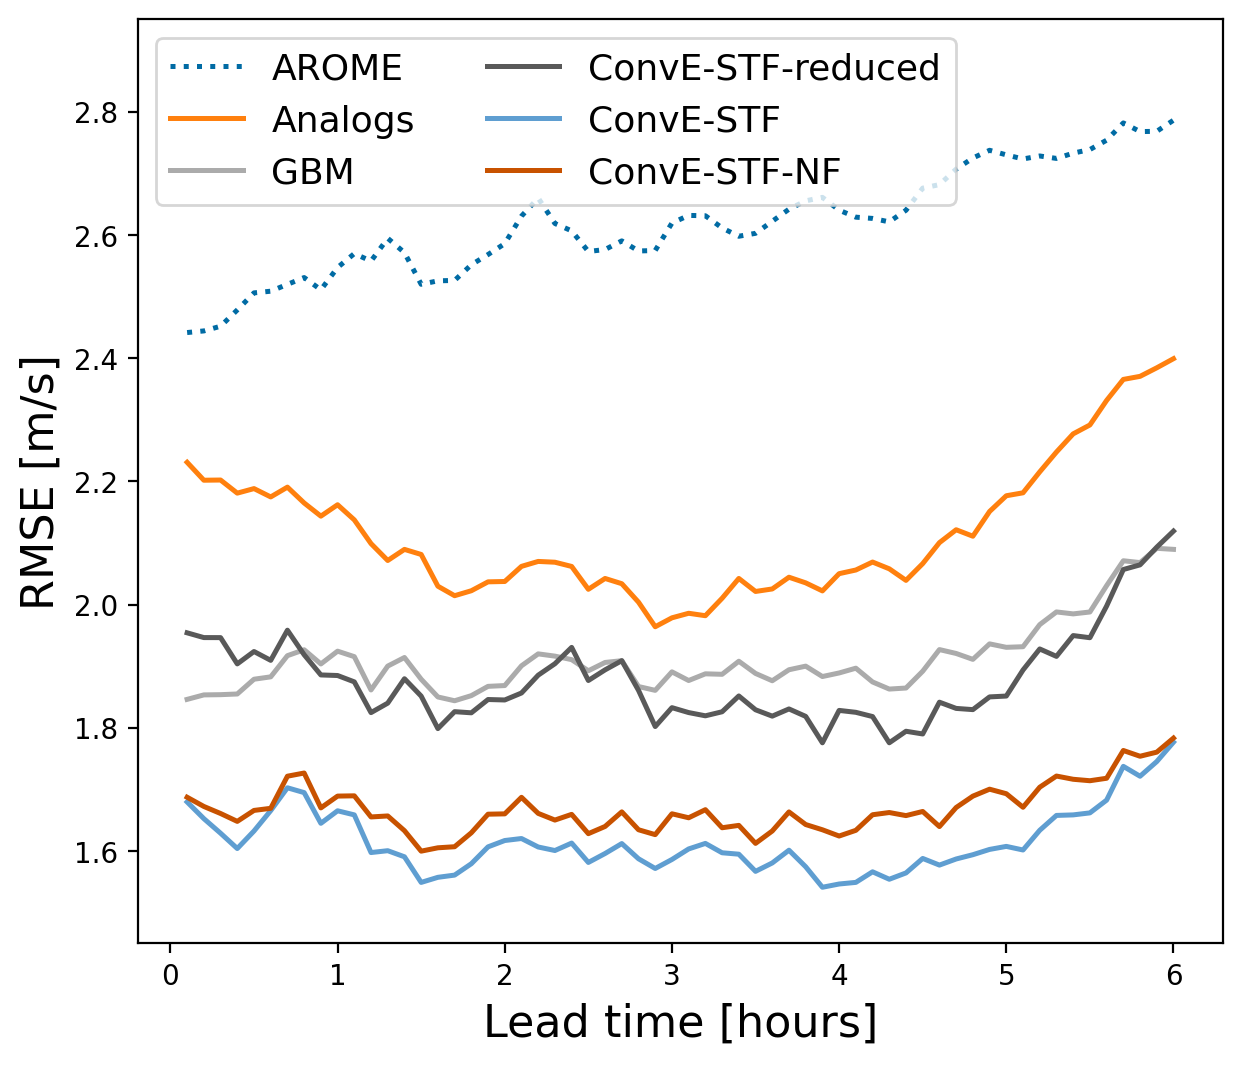

In [42]:
rmse_k = {}

for model in name_models:
    rmse_k[model] = torch.sqrt(scores_timestep[model]['mse'].reshape(N_issue_time, N_lead_time).mean(axis = 0))

with plt.style.context(("tableau-colorblind10",)):

    plt.figure(figsize = (7, 6))
    plt.plot([i*0.1 for i in range(1, 61)], rmse_k['arome'], label = 'AROME', linestyle = 'dotted', linewidth = 1.8)
    plt.plot([i*0.1 for i in range(1, 61)], rmse_k['analogs'], label = 'Analogs', linewidth = 1.8)
    plt.plot([i*0.1 for i in range(1, 61)], rmse_k['gbm'], label = 'GBM', linewidth = 1.8)
    plt.plot([i*0.1 for i in range(1, 61)], rmse_k['convestf_reduced'], label = 'ConvE-STF-reduced', linewidth = 1.8)
    plt.plot([i*0.1 for i in range(1, 61)], rmse_k['convestf'], label = 'ConvE-STF', linewidth = 1.8)
    plt.plot([i*0.1 for i in range(1, 61)], rmse_k['convestf_nf'], label = 'ConvE-STF-NF', linewidth = 1.8)
    plt.xlabel('Lead time [hours]', fontsize = 16)
    plt.ylabel('RMSE [m/s]', fontsize = 16)
    # plt.title('RMSE in the forecast window')
    plt.ylim([1.45, 2.95])
    plt.legend(ncol = 2, fontsize = 13)

Rank histograms are necessary to evaluate the forecasts calibration. The rank histograms are computed from samples. 

In [43]:
name_models = ['convestf', 'convestf_nf', 'convestf_reduced', 'gbm', 'analogs']
samples = {'convestf' : samples_convestf, 'convestf_nf' : samples_nf, 'convestf_reduced' : samples_convestf_reduced, 
           'gbm' : samples_gbm, 'analogs': samples_analogs}

In [76]:
def rank_histogram(samples, y):
    n_samples = samples.shape[1]
    n_vars = y.shape[1]
    samples = samples.permute(1, 2, 0, 3).contiguous().view(n_samples, n_vars, -1).permute(2, 0, 1)
    y = y.permute(1, 0, 2).contiguous().view(n_vars, -1).permute(1, 0)
    n_entries = y.shape[0]
    samples = torch.cat((samples, y.unsqueeze(1)), dim = 1)
    ranks = torch.zeros((n_entries, n_samples + 1))
    rank_final = torch.zeros((n_entries))
    for j in range(n_samples + 1):
        for d in range(n_vars):
            if d == 0:
                idx = (samples[:, :, d] < samples[:, j, d].unsqueeze(1))
            else:
                idx = idx*(samples[:, :, d] < samples[:, j, d].unsqueeze(1))
        ranks[:, j] = idx.sum(axis = 1)
    s_inf = (ranks < ranks[:, -1].unsqueeze(1)).sum(axis = 1)
    s_eq = (ranks  == ranks[:, -1].unsqueeze(1)).sum(axis = 1)
    for t in range(y.shape[0]):
        rank_final[t] = random.randint(s_inf[t] + 1, s_inf[t] + s_eq[t])/(n_samples+1)    

    quantiles = [0.1*i for i in range(1, 11)]
    n_quantiles = len(quantiles)
    n_tot_samples = rank_final.shape[0]
    n_samples_quant = 0
    n_samples_quant_cumsum = 0
    rel_idx = 0
    for i, quantile in enumerate(quantiles):
        n_samples_quant = (rank_final < quantile).sum() - n_samples_quant_cumsum
        n_samples_quant_cumsum = n_samples_quant_cumsum + n_samples_quant
        f_quant = n_samples_quant / n_tot_samples
        rel_idx = rel_idx + abs(f_quant - 1/n_quantiles)/n_quantiles*100
    return rank_final, rel_idx

In [78]:
freq = {}
hist2d = {}
rel_idx = {}

for name_model in tqdm(name_models):
    hist2d[name_model], rel_idx[name_model] = rank_histogram(samples[name_model], 
                                                             y['test'])
    freq[name_model], bin_edges = np.histogram(hist2d[name_model], bins = 10, density = True)

100%|██████████| 5/5 [02:18<00:00, 27.62s/it]


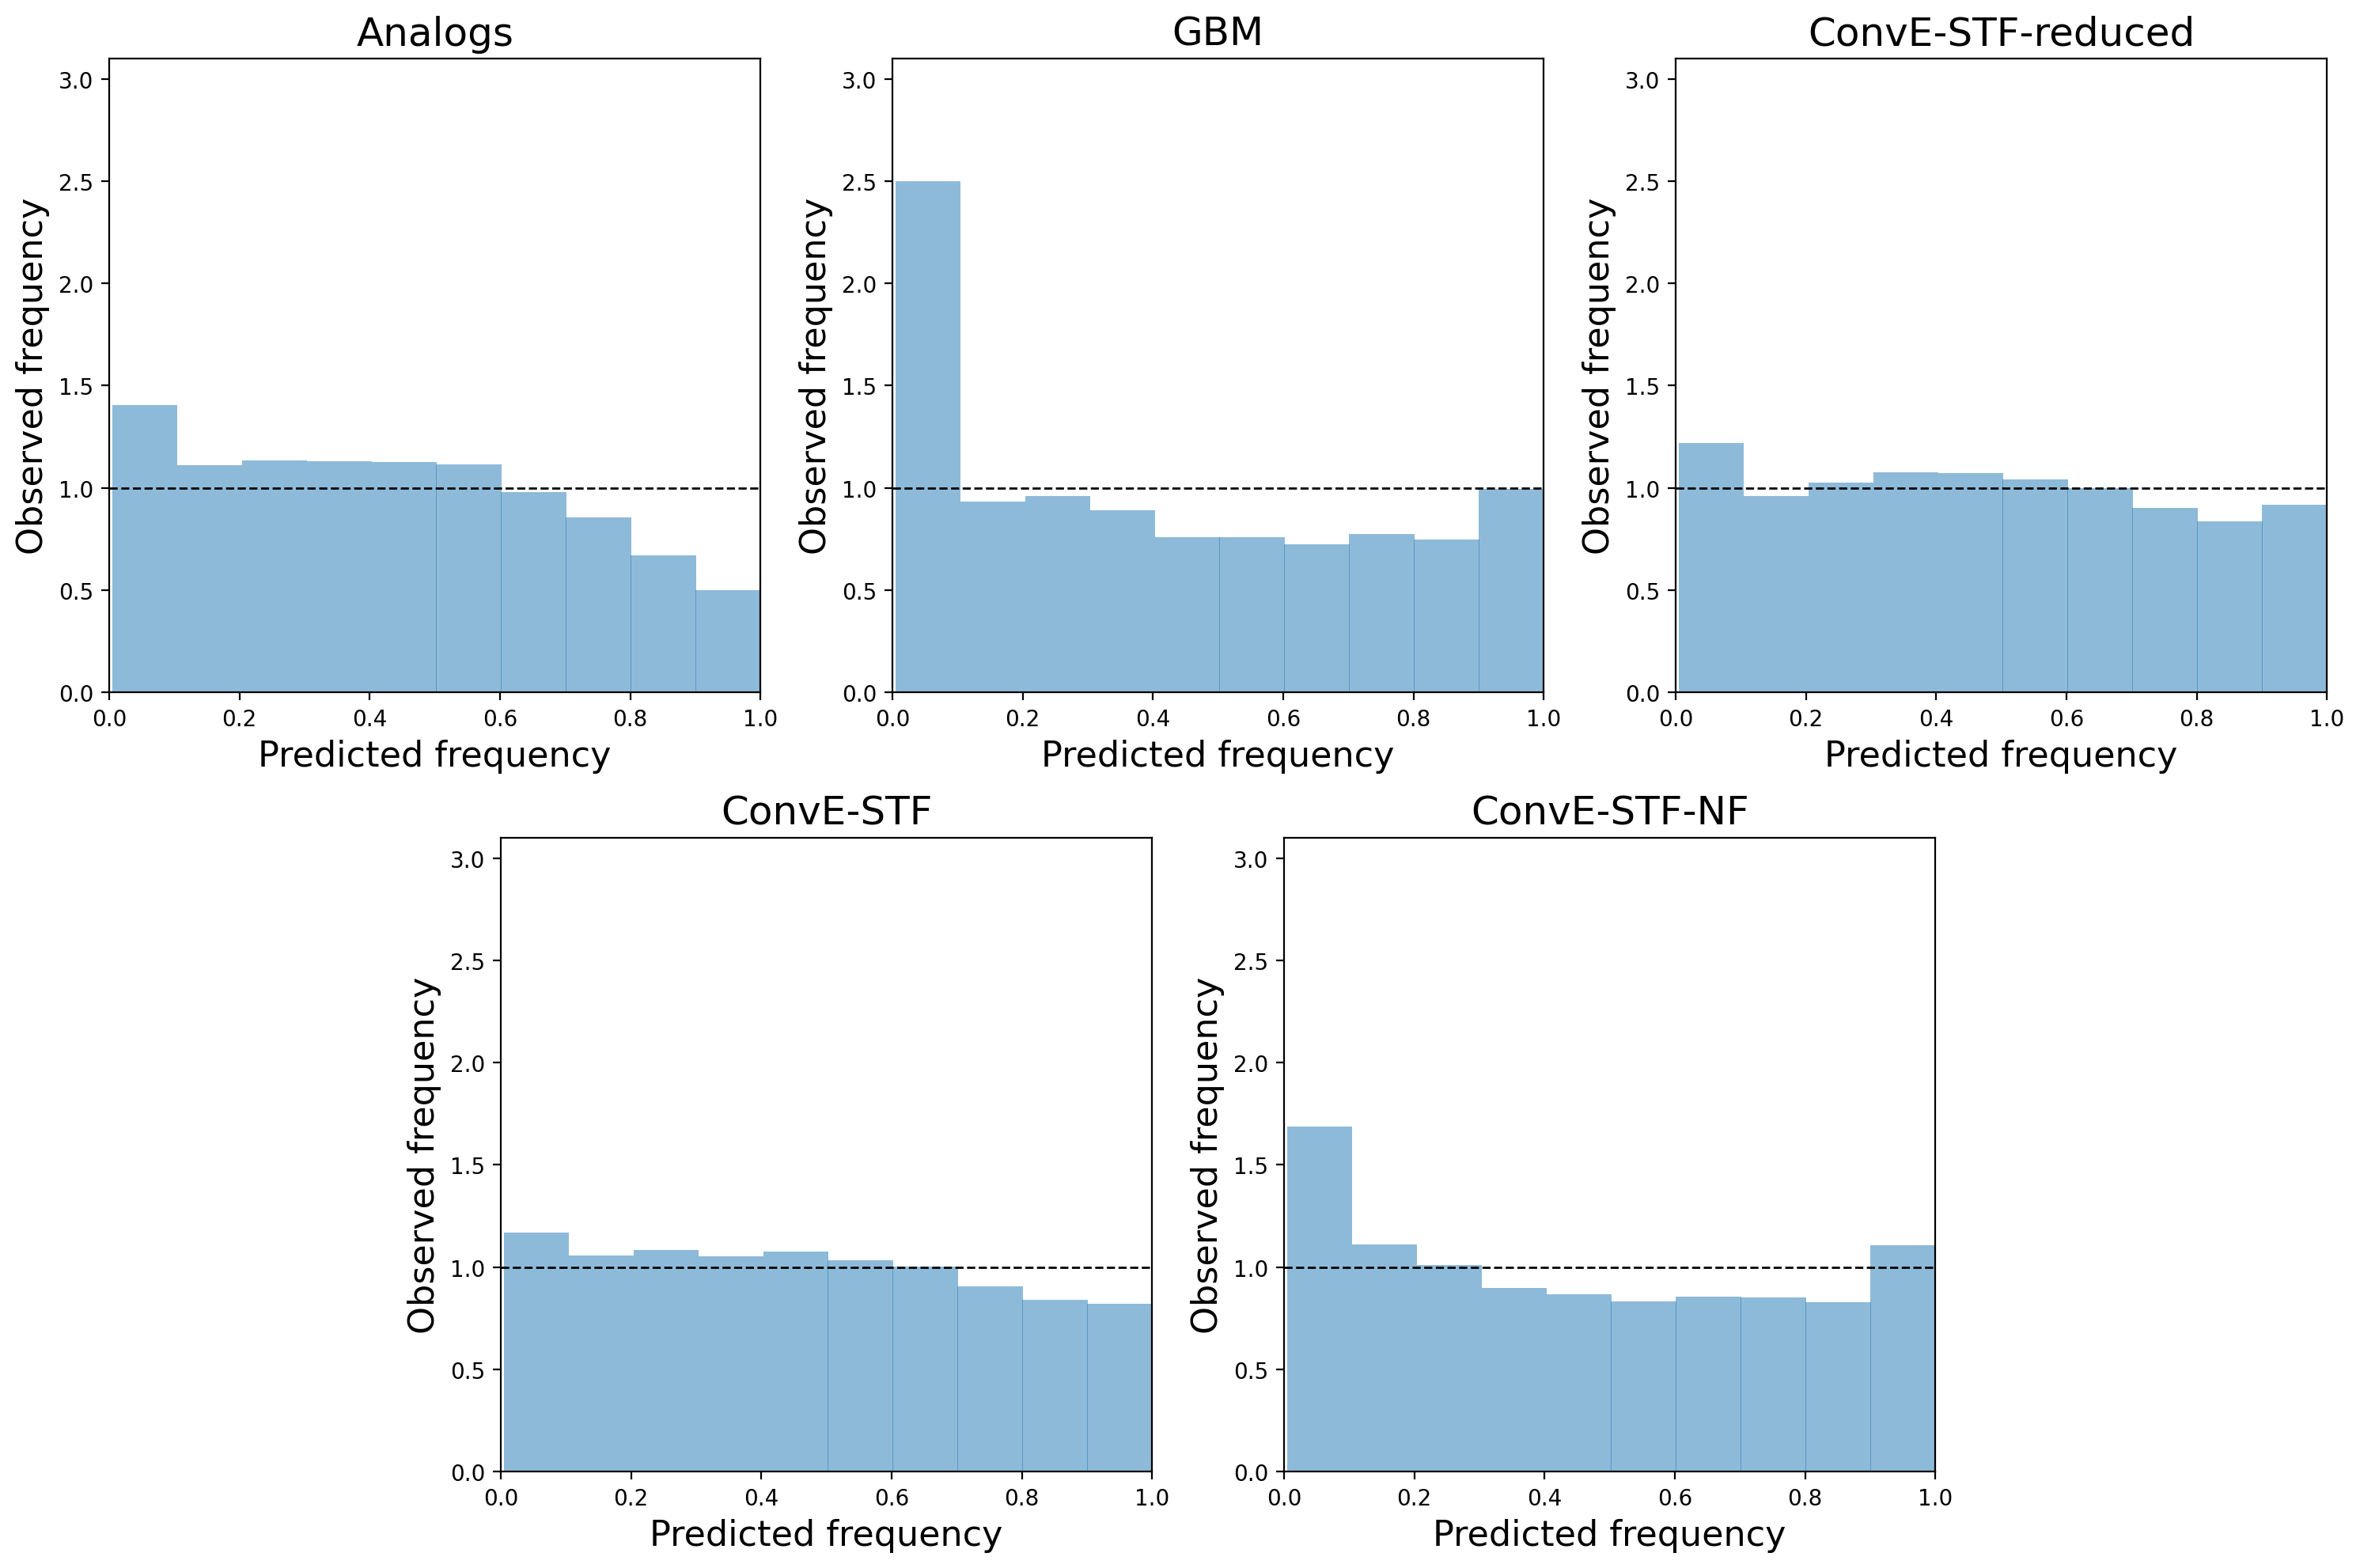

In [79]:
import matplotlib as mpl

bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
fig = plt.figure(figsize = (15, 10))
spec = mpl.gridspec.GridSpec(ncols=6, nrows=2)
axs = []
axs.append(fig.add_subplot(spec[0,0:2]))
axs.append(fig.add_subplot(spec[0,2:4]))
axs.append(fig.add_subplot(spec[0,4:]))
axs.append(fig.add_subplot(spec[1,1:3]))
axs.append(fig.add_subplot(spec[1,3:5]))
name_models = ['analogs', 'gbm', 'convestf_reduced', 'convestf', 'convestf_nf']

Name_Models = ['Analogs', 'GBM', 'ConvE-STF-reduced', 'ConvE-STF', 'ConvE-STF-NF']
for i, model in enumerate(name_models):
    mean_freq = freq[model]
    ax = axs[i]
    ax.bar(bin_centres, mean_freq, width=0.1, alpha = 0.5)

    ax.plot([0, 1], [1, 1], 'k--', linewidth = 1)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 3.1])
    ax.set_xticks(np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.set_xticklabels(np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0]))
    ax.set_title(Name_Models[i], fontsize = 18)
    ax.set_ylabel('Observed frequency', fontsize = 16)
    ax.set_xlabel('Predicted frequency', fontsize = 16)
plt.tight_layout()